In [1]:
# Imports the Library Functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Generate the sample KPIs data

np.random.seed(42)

n = 5000

df = pd.DataFrame({
    "site_id": np.random.randint(1001, 1100, n),
    "technology": np.random.choice(["4G","5G"], n, p=[0.6,0.4]),
    "active_users": np.random.randint(50, 500, n),
    "prb_util_dl": np.random.uniform(20, 100, n),
    "prb_util_ul": np.random.uniform(10, 90, n),
    "dl_throughput": np.random.uniform(5, 150, n),
    "ul_throughput": np.random.uniform(2, 60, n),
    "latency": np.random.uniform(5, 80, n),
    "rrc_sr": np.random.uniform(90, 100, n),
    "erab_sr": np.random.uniform(88, 100, n),
    "drop_rate": np.random.uniform(0.1, 5, n),
    "ho_sr": np.random.uniform(85, 100, n),
    "rsrp": np.random.uniform(-120, -70, n),
    "sinr": np.random.uniform(0, 30, n)
})

df.head()

,site_id,technology,active_users,prb_util_dl,prb_util_ul,dl_throughput,ul_throughput,latency,rrc_sr,erab_sr,drop_rate,ho_sr,rsrp,sinr
0,1052,4G,302,97.083968,59.656869,25.243836,17.030596,46.669994,90.041302,89.200793,1.545034,87.043299,-110.578583,27.261583
1,1093,4G,142,55.497222,80.566838,101.220373,55.708058,59.359597,94.233505,97.328774,1.098138,85.494951,-88.360993,25.724506
2,1015,4G,305,83.606997,38.111431,117.454525,55.996283,14.455383,96.871376,93.219392,4.376700,92.393774,-119.817977,16.941531
3,1072,4G,303,21.061483,54.213483,96.484509,26.133483,59.095435,96.225022,99.976700,0.465163,91.722293,-115.079396,26.872582
4,1061,5G,401,63.824927,61.370704,19.081511,24.837176,36.024964,94.456998,96.348132,1.029442,98.047059,-81.765826,3.237975


In [3]:
# Create Congestion Level

df["congested"] = (
    (df["prb_util_dl"] > 85) &
    (df["active_users"] > 300) &
    (df["dl_throughput"] < 25)
).astype(int)

df["congested"].value_counts()

congested
0    4947
1      53
Name: count, dtype: int64

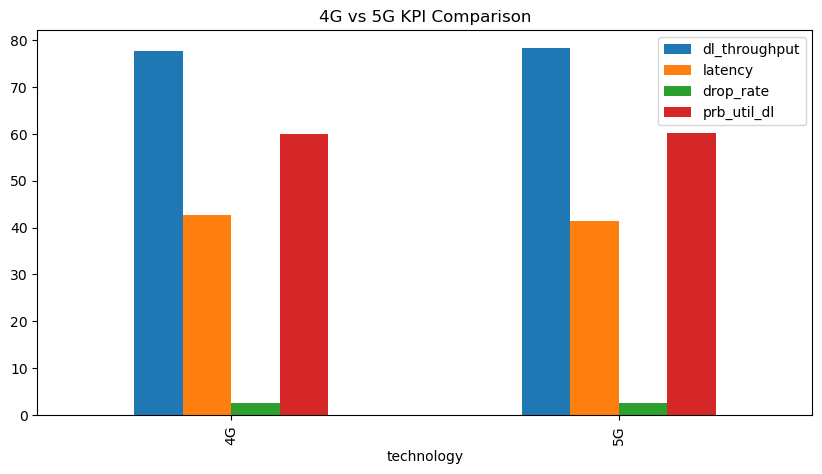

In [4]:
# Technology Comparison

tech_perf = df.groupby("technology")[[
    "dl_throughput","latency","drop_rate","prb_util_dl"
]].mean()

tech_perf.plot(kind="bar", figsize=(10,5))
plt.title("4G vs 5G KPI Comparison")
plt.show()

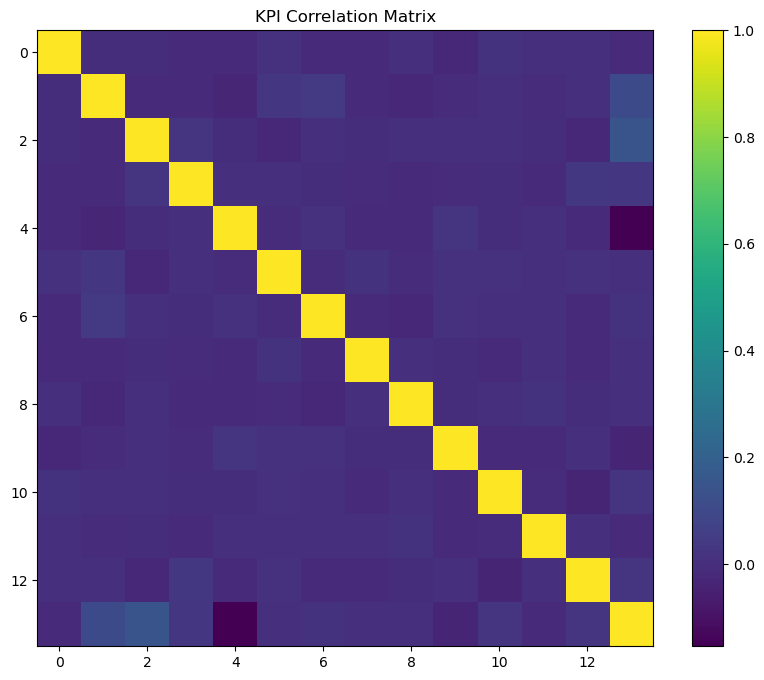

In [5]:
# KPI Correlation Matrix

corr = df.corr(numeric_only=True)

plt.figure(figsize=(10,8))
plt.imshow(corr)
plt.colorbar()
plt.title("KPI Correlation Matrix")
plt.show()

In [6]:
# Congestions Drivers Analysis

df.groupby("congested")[[
    "prb_util_dl","active_users","dl_throughput","latency"
]].mean()

,prb_util_dl,active_users,dl_throughput,latency
congested,,,,
0,59.716970,270.856479,78.594870,42.069140
1,92.735669,403.792453,15.155386,45.476278


In [7]:
# Risk-wise Site Ranking

site_risk = df.groupby("site_id").agg({
    "congested":"mean",
    "drop_rate":"mean",
    "dl_throughput":"mean"
}).sort_values("congested", ascending=False)

site_risk.head(10)

,congested,drop_rate,dl_throughput
site_id,,,
1004,0.058824,2.513708,71.673990
1028,0.056604,2.723481,78.714120
1091,0.054054,2.239785,78.893445
1020,0.042553,2.902843,74.440244
1085,0.041667,2.907007,77.578840
1023,0.041667,2.643699,81.182940
1029,0.038462,2.464830,75.400046
1015,0.036364,2.545981,81.602205
1082,0.035714,1.998281,65.451606


In [9]:
# Build the Congestions Prediction Model [ Features / Scale data / Train-Test Split / Train Model ]

features = [
    "active_users",
    "prb_util_dl",
    "prb_util_ul",
    "latency",
    "rsrp",
    "sinr"
]

X = df[features]
y = df["congested"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

model = LogisticRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)

print(classification_report(y_test, pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1487
           1       0.00      0.00      0.00        13

    accuracy                           0.99      1500
   macro avg       0.50      0.50      0.50      1500
weighted avg       0.98      0.99      0.99      1500



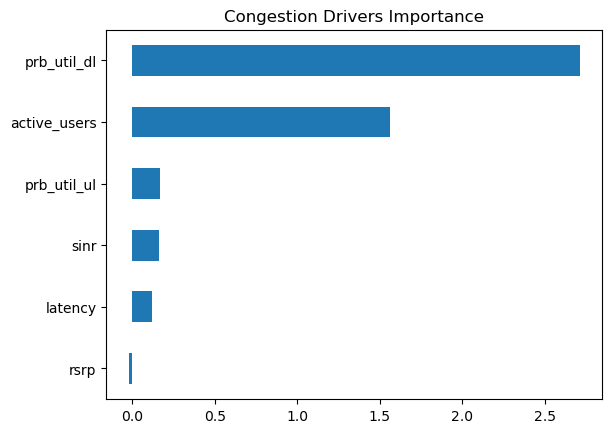

In [10]:
# Feature Importance

importance = pd.Series(
    model.coef_[0],
    index=features
).sort_values()

importance.plot(kind="barh")
plt.title("Congestion Drivers Importance")
plt.show()